## Imports

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
import seaborn as sns

from skimage.io import imread
from skimage.segmentation import chan_vese, watershed
from skimage.draw import ellipse
from scipy import ndimage as ndi
from sklearn.cluster import KMeans
from joblib import Parallel, delayed

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer

import tensorflow as tf
#from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

#from imblearn.pipeline import Pipeline
#from imblearn.over_sampling import RandomOverSampler
#from imblearn.under_sampling import RandomUnderSampler
#from imblearn.metrics import geometric_mean_score
#from imblearn.model_selection import GridSearchCVClassifier

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
import time
import os
import copy
import pandas as pd

import matplotlib.pyplot as plt

import cv2

import skimage.io 
import csv
import os

from joblib import Parallel, delayed
import multiprocessing
from math import sqrt
import pandas as pd

from tensorflow.keras.models import save_model, load_model

from skimage.measure import shannon_entropy
from skimage.metrics import structural_similarity as compare_ssim
from skimage.color import rgb2gray

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tqdm import tqdm
import joblib

2024-04-26 21:18:19.602384: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-26 21:18:35.610364: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Functions

In [2]:
#Load the images and the segmentation
def getImagesAndSegmentations(path):
    folder_path = path
    # Get a list of all files in the folder
    file_names = os.listdir(folder_path)
    file_names.sort()
    # Load all images from the folder
    # Arrays to store images and segmentations
    image_array = []
    segmentation_array = []
    
    # Load images and segmentations
    for i in range(len(file_names)):
        file_name = file_names[i]
        
        # Check if the file is a segmentation
        if file_name.endswith('_seg.jpg') or file_name.endswith('_seg.png'):
            # Load the segmentation
            seg = skimage.io.imread(os.path.join(folder_path, file_name))
            segmentation_array[-1] = [file_name,seg]
        else:
            # Load the image
            img = skimage.io.imread(os.path.join(folder_path, file_name))
            image_array.append([file_name, img])
            # If segmentation doesn't exist, store -1
            segmentation_array.append(-1)
            
    return image_array, segmentation_array

def otsuSegmentation(image):
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Apply Otsu's thresholding
    _, segmented_image = cv2.threshold(grayscale_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # Assuming arr is your NumPy array
    arr = np.array(segmented_image)
    
    # Replace 255 with 0 and 0 with 1
    segmented_image = np.where(arr == 255, 0, 1)
    
    return np.array(segmented_image).astype('uint8')

def dice_coef(seg1, seg2, orig):
        if seg1.shape != seg2.shape:
            raise ValueError("Shape mismatch: img and img2 must have to be of the same shape.")
        else:
            result = cv2.bitwise_and(orig, orig, mask=seg1)
            result2 = cv2.bitwise_and(orig, orig, mask=seg2)

            lenIntersection=0
            
            for i in range(result.shape[0]):
                for j in range(result.shape[1]):
                    if ( np.array_equal(result[i][j],result2[i][j]) ):
                        lenIntersection+=1
             
            lenimg=result.shape[0]*result.shape[1]
            lenimg2=result2.shape[0]*result2.shape[1]  
            value = (2. * lenIntersection  / (lenimg + lenimg2))
        return value

def resizeImages(images):
    # Define a common size for resizing the images
    target_size = (500, 300)  # Adjust this size as needed
    
    # Convert image data to numpy array and resize
    resized_images = []
    for image in tqdm(images):
        # Resize the image
        resized_img = cv2.resize(image, target_size)
        # Append to resized_images list
        resized_images.append(resized_img)
    return resized_images

def calculate_asymmetry(image):
    # Mirror the left half of the image
    mirrored = np.fliplr(image[:, :image.shape[1] // 2, :])
    # Compute structural similarity index (SSIM)
    # Ensure the window size does not exceed the smaller side of the image
    window_size = 3  # You can adjust this window size as needed (e.g., 3x3 or 5x5)
    ssim = compare_ssim(image[:, image.shape[1] // 2:, :], mirrored, multichannel=True, win_size=window_size)
    return ssim

def calculate_border_irregularity(image,i):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply Canny edge detection
    edges = cv2.Canny(gray, 100, 200)
    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Compute the perimeter of the largest contour
    perimeter = cv2.arcLength(contours[0], True)
    # Compute the area of the largest contour
    area = cv2.contourArea(contours[0])
    
    if area == 0:
        # Plot the image with contours
        print('position ' + str(i))
        plt.imshow(image)
        plt.title("Image with Contours (Area = 0)")
        plt.axis('off')
        for contour in contours:
            plt.plot(contour[:, 0, 0], contour[:, 0, 1], color='red', linewidth=2)
        plt.show()
    
    # Calculate compactness (perimeter^2 / area)
    compactness = (perimeter ** 2) / area
    return compactness

def calculate_color_features(image):
    # Convert image to Lab color space
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    # Split channels
    l, a, b = cv2.split(lab)
    # Calculate mean and standard deviation of each channel
    l_mean, l_std = np.mean(l), np.std(l)
    a_mean, a_std = np.mean(a), np.std(a)
    b_mean, b_std = np.mean(b), np.std(b)
    return l_mean, l_std, a_mean, a_std, b_mean, b_std

def calculate_dimension(image):
    # Compute area of the lesion
    area = np.sum(image > 0)
    # Compute bounding box of the lesion
    _, _, width, height = cv2.boundingRect(image)
    # Compute aspect ratio
    aspect_ratio = width / height
    return area, aspect_ratio

def calculateABCD(image):
    asymmetry_score = calculate_asymmetry(image)
    l_mean, l_std, a_mean, a_std, b_mean, b_std = calculate_color_features(image)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    area, aspect_ratio = calculate_dimension(gray_image)
    return [asymmetry_score, l_mean, l_std, a_mean, a_std, b_mean, b_std, area, aspect_ratio]

def calculateABCD_parallel(images):
    num_cores = multiprocessing.cpu_count()
    ABCD = Parallel(n_jobs=num_cores)(delayed(calculateABCD)(image) for image in images)
    return ABCD

## Load data

### Images

In [37]:
# Path to the folder containing the images
#train_folder_path = '../data/Train/Train/'
#train_images, train_seg = getImagesAndSegmentations(train_folder_path)
test_folder_path = '../data/Test/Test/'
test_images, test_seg = getImagesAndSegmentations(test_folder_path)
test_image_names, test_image_data = zip(*test_images)

### Metadata

In [4]:
# Assuming code.ipynb is in the code folder and you want to access data.csv in the data folder
metaDataTest = pd.read_csv('../data/metadataTest.csv')
metaDataTest = metaDataTest.sort_values('ID')

# Assuming code.ipynb is in the code folder and you want to access data.csv in the data folder
metaDataTrain = pd.read_csv('../data/metadataTrain.csv')
metaDataTrain = metaDataTrain.sort_values('ID').reset_index(drop=True)
#first_row = metaDataTrain.iloc[index_of_a]  # Extract the first row using iloc
#print(first_row[0])
train_SEX = metaDataTrain['SEX'].values
train_AGE = metaDataTrain['AGE'].values
train_POSITION = metaDataTrain['POSITION'].values

test_SEX = metaDataTest['SEX'].values
test_AGE = metaDataTest['AGE'].values
test_POSITION = metaDataTest['POSITION'].values

## Segmentate and Calculate Dice Score

### Training

In [5]:
#this function will both calculate the segmentations and store them in segmented_images
#and at the end calculate the dice score
segmented_images = []

def calculateAverageDice():
    # Initialize variables for calculating the average Dice score
    total_dice_score = 0
    num_segmented_images = 0
    
    # Loop through train_seg to calculate Dice score for images with segmentations
    for i in range(len(train_seg)):
        # Check if segmentation mask exists
        if train_seg[i] != -1:
            # Perform Otsu's segmentation on the corresponding image
            segmented_image = otsuSegmentation(train_images[i][1])
            segmented_images.append(cv2.bitwise_and(train_images[i][1], train_images[i][1], mask=train_seg[i][1]))
            # Calculate Dice score
            dice_score = dice_coef(train_seg[i][1], segmented_image, train_images[i][1])
            # Accumulate the total score
            total_dice_score += dice_score
            # Increment the count of segmented images
            num_segmented_images += 1
        else:
            segmented_image = otsuSegmentation(train_images[i][1])
            segmented_images.append(cv2.bitwise_and(train_images[i][1], train_images[i][1], mask=segmented_image))
    
    # Calculate the average Dice score
    if num_segmented_images > 0:
        average_dice_score = total_dice_score / num_segmented_images
    else:
        average_dice_score = 0
    return average_dice_score


average_dice_score = calculateAverageDice()
#average_dice_score = joblib_segmentation()
print("Average Dice Score:", average_dice_score)

Average Dice Score: 0.846433494882943


### Test

In [6]:
#this function will both calculate the segmentations and store them in segmented_images
#and at the end calculate the dice score
segmented_test_images = []

def calculateAverageDiceTest():
    # Initialize variables for calculating the average Dice score
    total_dice_score = 0
    num_segmented_images = 0
    
    # Loop through test_seg to calculate Dice score for images with segmentations
    for i in range(len(test_seg)):
        # Check if segmentation mask exists
        if test_seg[i] != -1:
            # Perform Otsu's segmentation on the corresponding image
            segmented_image = otsuSegmentation(test_images[i][1])
            segmented_test_images.append(cv2.bitwise_and(test_images[i][1], test_images[i][1], mask=test_seg[i][1]))
            # Calculate Dice score
            dice_score = dice_coef(test_seg[i][1], segmented_image, test_images[i][1])
            # Accumulate the total score
            total_dice_score += dice_score
            # Increment the count of segmented images
            num_segmented_images += 1
        else:
            segmented_image = otsuSegmentation(test_images[i][1])
            segmented_test_images.append(cv2.bitwise_and(test_images[i][1], test_images[i][1], mask=segmented_image))
    
    # Calculate the average Dice score
    if num_segmented_images > 0:
        average_dice_score = total_dice_score / num_segmented_images
    else:
        average_dice_score = 0
    return average_dice_score


average_dice_testscore = calculateAverageDiceTest()
print(average_dice_testscore)

0.8492443837935374


## Calculate ABCD Features

### Training

In [7]:
segmented_images = resizeImages(segmented_images)
abcd_train = calculateABCD_parallel(segmented_images)
# Save the calculated features in a file
np.save('featuresabcd.npy', abcd_train)
print('ABCD train features saved')

100%|██████████| 18998/18998 [00:17<00:00, 1062.45it/s]


ABCD train features saved


### Test

In [8]:
segmented_test_images = resizeImages(segmented_test_images)
abcd_test = calculateABCD_parallel(segmented_test_images)
np.save('featurestestabcd.npy', abcd_test)
print('ABCD test features saved')

100%|██████████| 6333/6333 [00:03<00:00, 1999.04it/s]


ABCD test features saved


## CNN ResNet

In [4]:
class CustomDataset(Dataset):
    def __init__(self, paths, labels, folder : str, transform):
        """
            paths : list of paths to the images
            labels : list of the labels (between 1 and 8)
            folder : folder containing the data
            transform : the transformation to apply
        """
        self.paths = paths
        self.labels = labels  
        self.transform = transform
        self.folder = folder
    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        # choose the file
        file = self.paths[idx]
        label = self.labels[idx]-1 # as the label provided are between 1 and 8 (included)
        # open the file
        inp = Image.open(os.path.join(self.folder,file+".jpg"))
        # Apply transformation
        if self.transform :
            inp = self.transform(inp)
                
        return inp, label

In [5]:
learning_rate = 1e-6
num_epochs = 24
batch_size = 64

num_classes = 8
feature_extract = False 

split = 0.15

In [7]:
df = pd.read_csv('../data/metadataTrain.csv')
paths = list(df["ID"])
labels = list(df["CLASS"])
val_size = int((1-split)*len(paths))

X_train, y_train, X_val, y_val = paths[:val_size], labels[:val_size], paths[val_size:], labels[val_size:]


img_transform = transforms.Compose([
        transforms.GaussianBlur(5, sigma=(0.1, 2.0)),
        transforms.RandomRotation(90),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize((256,256)),             # resize shortest side to 256 pixels
        transforms.CenterCrop(224),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

train_dataset = CustomDataset(X_train, y_train, '../data/Train/Train/', transform=img_transform)
val_dataset = CustomDataset(X_val, y_val, '../data/Train/Train/', transform=img_transform)


image_datasets = {'train':train_dataset, 'val':val_dataset}
dataloaders_dict = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

### Prueba Cristian

             ID  CLASS     SEX   AGE         POSITION
0  ISIC_0000000      2  female  55.0   anterior torso
1  ISIC_0000001      2  female  30.0   anterior torso
2  ISIC_0000002      1  female  60.0  upper extremity
3  ISIC_0000003      2    male  30.0  upper extremity
4  ISIC_0000004      1    male  80.0  posterior torso
5  ISIC_0000007      2  female  25.0  posterior torso
6  ISIC_0000008      2  female  30.0   anterior torso
7  ISIC_0000009      2  female  30.0   anterior torso
8  ISIC_0000010      2  female  35.0  posterior torso
9  ISIC_0000012      2    male  30.0  posterior torso
[2, 2, 1, 2, 1, 2, 2, 2, 2, 2]


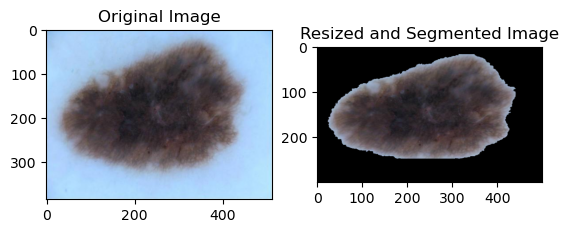

In [71]:
print(metaDataTrain.head(10))
first_column = [row[0] for row in train_images]
index_of_a = first_column.index('ISIC_0000002.jpg')
print(classes_train[:10])
# Plotting the first image
plt.subplot(1, 2, 1)  # 1 row, 2 columns, position 1
plt.imshow(train_images[index_of_a][1], cmap='gray')  # Assuming it's a grayscale image
plt.title('Original Image')

# Plotting the second image
plt.subplot(1, 2, 2)  # 1 row, 2 columns, position 2
plt.imshow(resized_segmented_train_images[2])  # Assuming it's a color image
plt.title('Resized and Segmented Image')

plt.show()

In [4]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        images : numpy array of images
        labels : list/array of the labels (between 1 and 8)
        transform : the transformation to apply
        """
        self.images = images
        self.labels = labels  
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        # Convert the numpy array to PIL Image
        image = Image.fromarray(image)
        label = self.labels[idx] - 1  # Adjust label to start from 0
        if self.transform:
            image = self.transform(image)
        return image, label

In [7]:
learning_rate = 1e-6
num_epochs = 10
batch_size = 64

num_classes = 8
feature_extract = False 

split = 0.15

In [6]:
df = pd.read_csv('../data/metadataTrain.csv')
paths = list(df["ID"])
labels = list(df["CLASS"])
val_size = int((1-split)*len(paths))

X_train, y_train, X_val, y_val = resized_segmented_train_images[:val_size], classes_train[:val_size], resized_segmented_train_images[val_size:], classes_train[val_size:]
#X_train has the name of the images
#y_train has the label of each of them

img_transform = transforms.Compose([
        transforms.GaussianBlur(5, sigma=(0.1, 2.0)),
        transforms.RandomRotation(90),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        #transforms.Resize((300,300)),             # resize shortest side to 256 pixels
        transforms.CenterCrop(350),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])


train_dataset = CustomDataset(X_train, y_train, transform=img_transform)
#esta linea de arriba es la que quiero ver y cambiar para utilizar mis imágenes
val_dataset = CustomDataset(X_val, y_val, transform=img_transform)


image_datasets = {'train':train_dataset, 'val':val_dataset}
dataloaders_dict = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

print(torch.cuda.is_available())
print(device)

True
cuda


### Initialize model

In [9]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(num_classes, feature_extract, use_pretrained=True):
    model = models.resnet152(pretrained=use_pretrained)
    set_parameter_requires_grad(model, feature_extract)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    input_size = 224
    
    return model

In [10]:
model = initialize_model(num_classes, feature_extract)

model = model.to(device)

params_to_update = model.parameters()
if feature_extract:
    params_to_update = []
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print(name)
else:
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(name)

# The parameters are optimizing
#optimizer = optim.Adam(params_to_update, lr=0.001)
#optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

optimizer = optim.Adam(
    [
        {"params": model.fc.parameters(), "lr": learning_rate},
        {"params": model.layer4.parameters(), "lr": learning_rate*10},
        {"params": model.layer3.parameters(), "lr": learning_rate},
        {"params": model.layer2.parameters(), "lr": learning_rate/10},
        {"params": model.layer1.parameters(), "lr": learning_rate/10}
    ],
    lr=learning_rate,
)

# Loss function
#criterion = nn.CrossEntropyLoss()

#to reduce the learning rate
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)

# weighted loss
weights = [0.7005531, 0.24592265, 0.95261733, 3.64804147, 1.20674543, 13.19375, 12.56547619, 5.04219745]
loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(weights).to(device))

#loss = torch.nn.CrossEntropyLoss()

/home/infres/cchavez-23/anaconda3/envs/myenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/infres/cchavez-23/anaconda3/envs/myenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /home/infres/cchavez-23/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
 42%|████▏     | 32.1M/77.4M [00:00<00:00, 73.3MB/s]

100%|██████████| 77.4M/77.4M [00:01<00:00, 79.4MB/s]


AttributeError: 'DenseNet' object has no attribute 'fc'

### Train model

In [ ]:
all_preds = []

def train_model(model, dataloaders, optimizer, criterion=loss, num_epochs=num_epochs):
    start = time.time()
    val_acc_history = []
    
    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        
        
        # Each epoch's training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()   # Do this if model is in training phase
            else:
                model.eval()    # Do this if model is in validation phase
                
            running_loss = 0
            running_corrects = 0
            
            # Iteration over the data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Parameter gradients are initialized to 0
                optimizer.zero_grad()
                
                # Forward Pass
                # Getting model outputs and calculating loss
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                        
                    _, preds = torch.max(outputs, 1)
                    all_preds.append(preds)  # Append preds to all_preds
                    
                    # Backward pass and Optimization in training phase 
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        #scheduler.step()
                
                # Stats
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds==labels.data)
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_weights = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

            print('-'*10)
                
    time_elapsed = time.time()
    
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    
    # Best model weights are loaded here
    model.load_state_dict(best_model_weights)
    return model, val_acc_history

In [ ]:
model, history = train_model(model, dataloaders_dict, optimizer, loss, num_epochs)

Epoch 0/9


train Loss: 1.5885 Acc: 0.4582
----------
val Loss: 1.8069 Acc: 0.3098
----------
Epoch 1/9
train Loss: 1.5903 Acc: 0.4572
----------
val Loss: 1.8090 Acc: 0.3077
----------
Epoch 2/9
train Loss: 1.5830 Acc: 0.4610
----------
val Loss: 1.8159 Acc: 0.3151
----------
Epoch 3/9


KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), 'model.pth')

### Test model

In [ ]:
class CustomTestDataset(Dataset):
    def __init__(self, paths, folder, transform):
        """
            paths : list of paths to the images
            labels : list of the labels (between 1 and 8)
            
            transform : the transformation to apply
        """
        self.paths = paths
        self.folder = folder
        self.transform = transform
        
    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        # choose the file
        file = self.paths[idx]
        
        # open the file
        inp = Image.open(os.path.join(self.folder,file+".jpg"))
        # Apply transformation
        if self.transform :
            inp = self.transform(inp)
                
        return inp,file

df_test = pd.read_csv("../data/metadataTest.csv")
paths = list(df_test["ID"])

img_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_dataset = CustomTestDataset(paths, '../data/Test/Test', transform=img_transform)

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# Set the model to evaluation mode
model.eval()

# Create empty lists to store the predictions
predictions = []
files = []


# Iterate over the test data
for images, file in test_dataloader:
    # Move the images to the device (e.g., GPU)
    images = images.to(device)
    
    # Forward pass through the model
    outputs = model(images)
    
    # Get the predicted labels or probabilities
    _, predicted = torch.max(outputs, 1)  # For classification
    predicted = torch.argmax(outputs, dim=1) + 1  # For multi-label classification
     
    # Append the predictions to the list
    files.extend(file)
    predictions.extend(predicted.tolist())

In [ ]:
# Convert predictions to a DataFrame
df_predictions = pd.DataFrame(predictions, columns=['CLASS'])

files = pd.Series(files, name='ID')

df_predictions = pd.concat([files, df_predictions], axis=1)

# Save DataFrame to CSV file
df_predictions.to_csv('prnj1.csv', index=False)

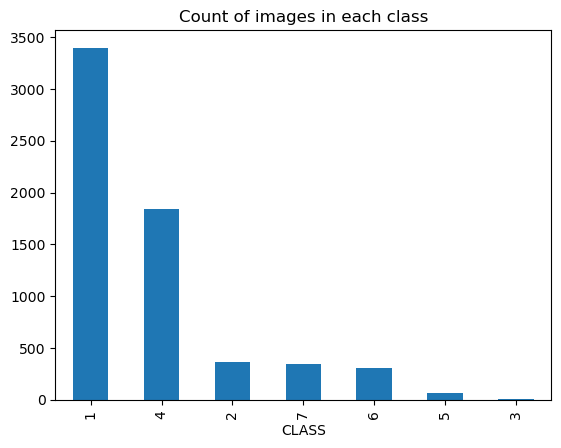

In [ ]:
#Plot the predictions classes
df_predictions['CLASS'].value_counts().plot(kind='bar')
plt.title('Count of images in each class')
plt.show()

### Predict training

In [ ]:
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image
import numpy as np
import pandas as pd

# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cargar el modelo previamente entrenado
model = initialize_model(num_classes, feature_extract)
model.load_state_dict(torch.load('model.pth', map_location=device))
model = model.to(device)
model.eval()  # Asegúrate de que el modelo esté en modo de evaluación

# Crear el conjunto de datos de entrenamiento
train_dataset = CustomDataset(resized_segmented_train_images, classes_train, transform=img_transform)  # Ajusta esta línea según tu implementación de CustomDataset

# Crear el dataloader para el conjunto de datos de entrenamiento
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Lista para almacenar las predicciones
all_predictions = []

# Iterar sobre el dataloader y obtener las predicciones del modelo
for inputs, _ in train_dataloader:  # Ignoramos las etiquetas (_)
    inputs = inputs.to(device)
    with torch.no_grad():  # Deshabilitar el cálculo de gradientes
        outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)  # Obtener las predicciones
    predicted = torch.argmax(outputs, dim=1) + 1  # For multi-label classification
    all_predictions.extend(predicted.cpu().numpy())  # Agregar las predicciones a la lista

# Convertir las predicciones a un array numpy
all_predictions = np.array(all_predictions)

# Imprimir las predicciones
print("Predicciones del modelo en el conjunto de datos de entrenamiento:", all_predictions)

# Convertir la lista de predicciones a un DataFrame de pandas
predictions_df = pd.DataFrame({'Prediction': all_predictions})

# Create the directory if it doesn't exist
output_dir = 'train_predictions'
os.makedirs(output_dir, exist_ok=True)

# Guardar el DataFrame en un archivo CSV en la carpeta "train_predictions" sin índices
predictions_df.to_csv(os.path.join(output_dir, 'train_pred.csv'), index=False, header=False)


Predicciones del modelo en el conjunto de datos de entrenamiento: [1 2 1 ... 1 8 1]


In [ ]:
# Load the CSV file into a DataFrame
predictions_df = pd.read_csv('train_predictions/train_pred.csv', header=None)

# Extract the predictions column as a list
all_predictions = np.array(predictions_df[0].tolist())

# Print the length of the list
print("Length of all_predictions:", len(all_predictions))

print(type(all_predictions))

Length of all_predictions: 18998
<class 'numpy.ndarray'>


In [ ]:
# Concatenate all_predictions to the left of abcd_train
all_features = np.concatenate((all_predictions[:, np.newaxis], abcd_train), axis=1)

# Check the shape of all_features
print("Shape of all_features:", all_features.shape)

Shape of all_features: (18998, 10)


## CNN All

In [ ]:
all_features.shape[1]

10

### Define 2nd network

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the architecture of the second neural network
class SecondNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(SecondNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, output_size)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define the size of the input and output for the second network
input_size_second = all_features.shape[1]  # Assuming the input size matches the number of features in all_features
output_size_second = num_classes  # Assuming the output size is the number of classes

# Initialize the second neural network
second_model = SecondNetwork(input_size_second, output_size_second)

# Move the second model to the appropriate device (GPU)
second_model = second_model.to(device)

# Convert the all_features numpy array to a PyTorch tensor and move it to the appropriate device (GPU)
all_features_tensor = torch.tensor(all_features, dtype=torch.float32).to(device)

# Pass the tensor through the second neural network to obtain the predictions
with torch.no_grad():
    outputs_second_model = second_model(all_features_tensor)

# Assuming outputs_second_model contains the predictions
# You can convert it to numpy array if needed
outputs_second_model_numpy = outputs_second_model.cpu().numpy()



RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


### train it

In [ ]:
# Define a custom dataset for the second neural network
class CustomSecondDataset(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Assuming you have labels for your samples, if not, you can skip this step
labels = classes_train  # Provide the labels for your dataset

# Define your dataset using the custom dataset class
second_dataset = CustomSecondDataset(all_features_tensor, labels)

# Define your dataloader
batch_size_second = 64
second_dataloader = torch.utils.data.DataLoader(second_dataset, batch_size=batch_size_second, shuffle=True)

# Define the loss function and optimizer for the second neural network
second_criterion = torch.nn.CrossEntropyLoss()
second_optimizer = torch.optim.Adam(second_model.parameters(), lr=learning_rate)

# Train the second neural network
for epoch in range(num_epochs):
    second_model.train()  # Set the model to training mode
    running_loss = 0.0
    for inputs, labels in second_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        # Zero the parameter gradients
        second_optimizer.zero_grad()
        # Forward pass
        outputs = second_model(inputs)
        loss = second_criterion(outputs, labels)
        # Backward pass and optimization
        loss.backward()
        second_optimizer.step()
        # Print statistics
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(second_dataset)
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, epoch_loss))


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


## Densenet

### Initialize model

In [7]:
class CustomDataset(Dataset):
    def __init__(self, paths, labels, folder: str, transform):
        self.paths = paths
        self.labels = labels
        self.transform = transform
        self.folder = folder

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        file = self.paths[idx]
        label = self.labels[idx] - 1
        inp = Image.open(os.path.join(self.folder, file + ".jpg"))
        if self.transform:
            inp = self.transform(inp)
        return inp, label

learning_rate = 1e-6
num_epochs = 32
batch_size = 64
num_classes = 8
feature_extract = False 
split = 0.15

df = pd.read_csv('../data/metadataTrain.csv')
paths = list(df["ID"])
labels = list(df["CLASS"])
val_size = int((1 - split) * len(paths))

X_train, y_train, X_val, y_val = paths[:val_size], labels[:val_size], paths[val_size:], labels[val_size:]

img_transform = transforms.Compose([
    transforms.GaussianBlur(5, sigma=(0.1, 2.0)),
    transforms.RandomRotation(90),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

train_dataset = CustomDataset(X_train, y_train, '../data/Train/Train/', transform=img_transform)
val_dataset = CustomDataset(X_val, y_val, '../data/Train/Train/', transform=img_transform)

image_datasets = {'train': train_dataset, 'val': val_dataset}
dataloaders_dict = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(num_classes, feature_extract, use_pretrained=True):
    model = models.densenet201(pretrained=use_pretrained)
    set_parameter_requires_grad(model, feature_extract)
    num_features = model.classifier.in_features
    model.classifier = nn.Linear(num_features, num_classes)
    input_size = 224
    return model

model = initialize_model(num_classes, feature_extract)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

params_to_update = model.parameters()
if feature_extract:
    params_to_update = []
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print(name)
else:
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(name)

optimizer = optim.Adam(
    [
        {"params": model.classifier.parameters(), "lr": learning_rate},
        {"params": model.features.denseblock4.parameters(), "lr": learning_rate * 10},
        {"params": model.features.denseblock3.parameters(), "lr": learning_rate},
        {"params": model.features.denseblock2.parameters(), "lr": learning_rate / 10},
        {"params": model.features.denseblock1.parameters(), "lr": learning_rate / 10}
    ],
    lr=learning_rate,
)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)

weights = [0.7005531, 0.24592265, 0.95261733, 3.64804147, 1.20674543, 13.19375, 12.56547619, 5.04219745]
loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(weights).to(device))


/home/infres/cchavez-23/anaconda3/envs/myenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/infres/cchavez-23/anaconda3/envs/myenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


features.conv0.weight
features.norm0.weight
features.norm0.bias
features.denseblock1.denselayer1.norm1.weight
features.denseblock1.denselayer1.norm1.bias
features.denseblock1.denselayer1.conv1.weight
features.denseblock1.denselayer1.norm2.weight
features.denseblock1.denselayer1.norm2.bias
features.denseblock1.denselayer1.conv2.weight
features.denseblock1.denselayer2.norm1.weight
features.denseblock1.denselayer2.norm1.bias
features.denseblock1.denselayer2.conv1.weight
features.denseblock1.denselayer2.norm2.weight
features.denseblock1.denselayer2.norm2.bias
features.denseblock1.denselayer2.conv2.weight
features.denseblock1.denselayer3.norm1.weight
features.denseblock1.denselayer3.norm1.bias
features.denseblock1.denselayer3.conv1.weight
features.denseblock1.denselayer3.norm2.weight
features.denseblock1.denselayer3.norm2.bias
features.denseblock1.denselayer3.conv2.weight
features.denseblock1.denselayer4.norm1.weight
features.denseblock1.denselayer4.norm1.bias
features.denseblock1.denselaye

### Initialize Cristian

In [7]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        images : numpy array of images
        labels : list/array of the labels (between 1 and 8)
        transform : the transformation to apply
        """
        self.images = images
        self.labels = labels  
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        # Convert the numpy array to PIL Image
        image = Image.fromarray(image)
        label = self.labels[idx] - 1  # Adjust label to start from 0
        if self.transform:
            image = self.transform(image)
        return image, label

learning_rate = 1e-6
num_epochs = 40
batch_size = 64
num_classes = 8
feature_extract = False 
split = 0.2

df = pd.read_csv('../data/metadataTrain.csv')
paths = list(df["ID"])
labels = list(df["CLASS"])
val_size = int((1 - split) * len(paths))

X_train, y_train, X_val, y_val = segmented_train_images[:val_size], classes_train[:val_size], segmented_train_images[val_size:], classes_train[val_size:]

img_transform = transforms.Compose([
    transforms.GaussianBlur(5, sigma=(0.1, 2.0)),
    transforms.RandomRotation(90),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

train_dataset = CustomDataset(X_train, y_train, transform=img_transform)
#esta linea de arriba es la que quiero ver y cambiar para utilizar mis imágenes
val_dataset = CustomDataset(X_val, y_val, transform=img_transform)


image_datasets = {'train':train_dataset, 'val':val_dataset}
dataloaders_dict = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(num_classes, feature_extract, use_pretrained=True):
    model = models.densenet201(pretrained=use_pretrained)
    set_parameter_requires_grad(model, feature_extract)
    num_features = model.classifier.in_features
    model.classifier = nn.Linear(num_features, num_classes)
    input_size = 224
    return model

model = initialize_model(num_classes, feature_extract)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

params_to_update = model.parameters()
if feature_extract:
    params_to_update = []
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print(name)
else:
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(name)

optimizer = optim.Adam(
    [
        {"params": model.classifier.parameters(), "lr": learning_rate},
        {"params": model.features.denseblock4.parameters(), "lr": learning_rate * 10},
        {"params": model.features.denseblock3.parameters(), "lr": learning_rate},
        {"params": model.features.denseblock2.parameters(), "lr": learning_rate / 10},
        {"params": model.features.denseblock1.parameters(), "lr": learning_rate / 10}
    ],
    lr=learning_rate,
)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)

weights = [0.7005531, 0.24592265, 0.95261733, 3.64804147, 1.20674543, 13.19375, 12.56547619, 5.04219745]
loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(weights).to(device))

/home/infres/cchavez-23/anaconda3/envs/myenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/infres/cchavez-23/anaconda3/envs/myenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


features.conv0.weight
features.norm0.weight
features.norm0.bias
features.denseblock1.denselayer1.norm1.weight
features.denseblock1.denselayer1.norm1.bias
features.denseblock1.denselayer1.conv1.weight
features.denseblock1.denselayer1.norm2.weight
features.denseblock1.denselayer1.norm2.bias
features.denseblock1.denselayer1.conv2.weight
features.denseblock1.denselayer2.norm1.weight
features.denseblock1.denselayer2.norm1.bias
features.denseblock1.denselayer2.conv1.weight
features.denseblock1.denselayer2.norm2.weight
features.denseblock1.denselayer2.norm2.bias
features.denseblock1.denselayer2.conv2.weight
features.denseblock1.denselayer3.norm1.weight
features.denseblock1.denselayer3.norm1.bias
features.denseblock1.denselayer3.conv1.weight
features.denseblock1.denselayer3.norm2.weight
features.denseblock1.denselayer3.norm2.bias
features.denseblock1.denselayer3.conv2.weight
features.denseblock1.denselayer4.norm1.weight
features.denseblock1.denselayer4.norm1.bias
features.denseblock1.denselaye

### Train it

In [8]:
import time
import copy

all_preds = []

def train_model(model, dataloaders, optimizer, criterion=loss, num_epochs=num_epochs):
    val_acc_history = []
    
    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0
    
    for epoch in range(num_epochs):
        epoch_start_time = time.time()  # Record start time of the epoch
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        
        # Each epoch's training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()   # Set model to training mode
            else:
                model.eval()    # Set model to evaluation mode
                
            running_loss = 0
            running_corrects = 0
            
            # Iteration over the data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass, track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                        
                    _, preds = torch.max(outputs, 1)
                    all_preds.append(preds)  # Append preds to all_preds
                    
                    # Backward pass + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        #scheduler.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_weights = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

            print('-' * 10)
        
        epoch_end_time = time.time()  # Record end time of the epoch
        epoch_time = epoch_end_time - epoch_start_time  # Calculate epoch duration
        print('Epoch time: {:.0f}m {:.0f}s'.format(epoch_time // 60, epoch_time % 60))  # Print epoch time
        
    print('Training complete')
    print('Best val Acc: {:.4f}'.format(best_acc))
    
    # Load best model weights
    model.load_state_dict(best_model_weights)
    return model, val_acc_history

model, history = train_model(model, dataloaders_dict, optimizer, loss, num_epochs)


Epoch 0/39


train Loss: 1.9274 Acc: 0.3091
----------
val Loss: 1.8830 Acc: 0.3171
----------
Epoch time: 1m 1s
Epoch 1/39
train Loss: 1.6763 Acc: 0.4077
----------
val Loss: 1.7643 Acc: 0.3555
----------
Epoch time: 1m 0s
Epoch 2/39
train Loss: 1.5341 Acc: 0.4693
----------
val Loss: 1.7129 Acc: 0.3705
----------
Epoch time: 0m 58s
Epoch 3/39
train Loss: 1.4510 Acc: 0.5080
----------
val Loss: 1.6499 Acc: 0.3911
----------
Epoch time: 0m 59s
Epoch 4/39


### Test

In [13]:
# Save the trained model's state dictionary
torch.save(model.state_dict(), 'modeldn201.pth')

# Define a custom test dataset
class CustomTestDataset(Dataset):
    def __init__(self, paths, folder, transform):
        self.paths = paths
        self.folder = folder
        self.transform = transform
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        file = self.paths[idx]
        inp = Image.open(os.path.join(self.folder, file + ".jpg"))
        if self.transform:
            inp = self.transform(inp)
        return inp, file

# Load the test dataset
df_test = pd.read_csv("../data/metadataTest.csv")
paths = list(df_test["ID"])

img_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_dataset = CustomTestDataset(paths, '../data/Test/Test', transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# Set the model to evaluation mode
model.eval()

# Create empty lists to store the predictions
predictions = []
files = []

# Iterate over the test data
for images, file in test_dataloader:
    images = images.to(device)
    
    # Forward pass through the model
    outputs = model(images)
    
    # Get the predicted labels or probabilities
    _, predicted = torch.max(outputs, 1)  # For classification
    predicted = torch.argmax(outputs, dim=1) + 1  # For multi-label classification
     
    # Append the predictions to the list
    files.extend(file)
    predictions.extend(predicted.tolist())

# Convert predictions to a DataFrame
df_predictions = pd.DataFrame(predictions, columns=['CLASS'])
files = pd.Series(files, name='ID')
df_predictions = pd.concat([files, df_predictions], axis=1)

# Save DataFrame to CSV file
df_predictions.to_csv('pdn201.csv', index=False)

OutOfMemoryError: CUDA out of memory. Tried to allocate 98.00 MiB. GPU 0 has a total capacity of 39.39 GiB of which 15.31 MiB is free. Process 43896 has 25.29 GiB memory in use. Including non-PyTorch memory, this process has 14.07 GiB memory in use. Of the allocated memory 12.98 GiB is allocated by PyTorch, and 576.70 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## Inception

In [7]:
import time
import copy

class CustomDataset(Dataset):
    def __init__(self, paths, labels, folder: str, transform):
        self.paths = paths
        self.labels = labels
        self.transform = transform
        self.folder = folder

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        file = self.paths[idx]
        label = self.labels[idx] - 1
        inp = Image.open(os.path.join(self.folder, file + ".jpg"))
        if self.transform:
            inp = self.transform(inp)
        return inp, label

learning_rate = 1e-6
num_epochs = 24
batch_size = 64
num_classes = 8
feature_extract = False 
split = 0.15

df = pd.read_csv('../data/metadataTrain.csv')
paths = list(df["ID"])
labels = list(df["CLASS"])
val_size = int((1 - split) * len(paths))

X_train, y_train, X_val, y_val = paths[:val_size], labels[:val_size], paths[val_size:], labels[val_size:]

img_transform = transforms.Compose([
    transforms.GaussianBlur(5, sigma=(0.1, 2.0)),
    transforms.RandomRotation(90),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((299, 299)),  # Inception_v3 input size
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

train_dataset = CustomDataset(X_train, y_train, '../data/Train/Train/', transform=img_transform)
val_dataset = CustomDataset(X_val, y_val, '../data/Train/Train/', transform=img_transform)

image_datasets = {'train': train_dataset, 'val': val_dataset}
dataloaders_dict = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

def initialize_model(num_classes, feature_extract, use_pretrained=True):
    model = models.inception_v3(pretrained=use_pretrained)
    set_parameter_requires_grad(model, feature_extract)
    # Handle the auxilary net
    num_ftrs = model.AuxLogits.fc.in_features
    model.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
    # Handle the primary net
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, num_classes)
    input_size = 299  # Expected input size for Inception_v3
    return model

model = initialize_model(num_classes, feature_extract)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

params_to_update = model.parameters()
if feature_extract:
    params_to_update = []
    for name, param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print(name)
else:
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(name)

optimizer = optim.Adam(
    [
        {"params": model.fc.parameters(), "lr": learning_rate},
        {"params": model.AuxLogits.fc.parameters(), "lr": learning_rate},
        {"params": model.Mixed_7c.parameters(), "lr": learning_rate},
        {"params": model.Mixed_7b.parameters(), "lr": learning_rate / 10},
        {"params": model.Mixed_7a.parameters(), "lr": learning_rate / 10},
    ],
    lr=learning_rate,
)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)

weights = [0.7005531, 0.24592265, 0.95261733, 3.64804147, 1.20674543, 13.19375, 12.56547619, 5.04219745]
loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(weights).to(device))



/home/infres/cchavez-23/anaconda3/envs/myenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/infres/cchavez-23/anaconda3/envs/myenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Conv2d_1a_3x3.conv.weight
Conv2d_1a_3x3.bn.weight
Conv2d_1a_3x3.bn.bias
Conv2d_2a_3x3.conv.weight
Conv2d_2a_3x3.bn.weight
Conv2d_2a_3x3.bn.bias
Conv2d_2b_3x3.conv.weight
Conv2d_2b_3x3.bn.weight
Conv2d_2b_3x3.bn.bias
Conv2d_3b_1x1.conv.weight
Conv2d_3b_1x1.bn.weight
Conv2d_3b_1x1.bn.bias
Conv2d_4a_3x3.conv.weight
Conv2d_4a_3x3.bn.weight
Conv2d_4a_3x3.bn.bias
Mixed_5b.branch1x1.conv.weight
Mixed_5b.branch1x1.bn.weight
Mixed_5b.branch1x1.bn.bias
Mixed_5b.branch5x5_1.conv.weight
Mixed_5b.branch5x5_1.bn.weight
Mixed_5b.branch5x5_1.bn.bias
Mixed_5b.branch5x5_2.conv.weight
Mixed_5b.branch5x5_2.bn.weight
Mixed_5b.branch5x5_2.bn.bias
Mixed_5b.branch3x3dbl_1.conv.weight
Mixed_5b.branch3x3dbl_1.bn.weight
Mixed_5b.branch3x3dbl_1.bn.bias
Mixed_5b.branch3x3dbl_2.conv.weight
Mixed_5b.branch3x3dbl_2.bn.weight
Mixed_5b.branch3x3dbl_2.bn.bias
Mixed_5b.branch3x3dbl_3.conv.weight
Mixed_5b.branch3x3dbl_3.bn.weight
Mixed_5b.branch3x3dbl_3.bn.bias
Mixed_5b.branch_pool.conv.weight
Mixed_5b.branch_pool.bn.weig

### Train it

In [10]:
all_preds = []

def train_model(model, dataloaders, optimizer, criterion=loss, num_epochs=num_epochs):
    val_acc_history = []
    
    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0
    
    for epoch in range(num_epochs):
        epoch_start_time = time.time()  # Record start time of the epoch
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    # Forward pass
                    outputs, _ = model(inputs)  # Inception_v3 returns a tuple of outputs
                    
                    # Calculate loss
                    loss = criterion(outputs, labels)
                        
                    _, preds = torch.max(outputs, 1)
                    all_preds.append(preds)
                    
                    if phase == 'train':
                        # Backward pass + optimize only if in training phase
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_weights = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

            print('-' * 10)
        
        epoch_end_time = time.time()  # Record end time of the epoch
        epoch_time = epoch_end_time - epoch_start_time  # Calculate epoch duration
        print('Epoch time: {:.0f}m {:.0f}s'.format(epoch_time // 60, epoch_time % 60))  # Print epoch time
                
    print('Training complete')
    print('Best val Acc: {:.4f}'.format(best_acc))
    
    model.load_state_dict(best_model_weights)
    return model, val_acc_history

model, history = train_model(model, dataloaders_dict, optimizer, loss, num_epochs)

torch.save(model.state_dict(), 'inception_v3_model.pth')

Epoch 0/23


RuntimeError: cuDNN error: CUDNN_STATUS_INTERNAL_ERROR

### Test

In [ ]:
class CustomTestDataset(Dataset):
    def __init__(self, paths, folder, transform):
        self.paths = paths
        self.folder = folder
        self.transform = transform
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        file = self.paths[idx]
        inp = Image.open(os.path.join(self.folder, file + ".jpg"))
        if self.transform:
            inp = self.transform(inp)
        return inp, file

df_test = pd.read_csv("../data/metadataTest.csv")
paths = list(df_test["ID"])

img_transform = transforms.Compose([
        transforms.RandomResizedCrop(299),  # Inception_v3 input size
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_dataset = CustomTestDataset(paths, '../data/Test/Test', transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

model.eval()

predictions = []
files = []

for images, file in test_dataloader:
    images = images.to(device)
    outputs, _ = model(images)  # Inception_v3 returns a tuple of outputs
    _, predicted = torch.max(outputs, 1)
    predicted = torch.argmax(outputs, dim=1) + 1
    files.extend(file)
    predictions.extend(predicted.tolist())

df_predictions = pd.DataFrame(predictions, columns=['CLASS'])
files = pd.Series(files, name='ID')
df_predictions = pd.concat([files, df_predictions], axis=1)
df_predictions.to_csv('inception_v3_predictions.csv', index=False)



## Non-linear SVM

### Training

In [ ]:
weights = [0.7005531, 0.24592265, 0.95261733, 3.64804147, 1.20674543, 13.19375, 12.56547619, 5.04219745]
# Definir el conjunto de pesos para cada muestra
sample_weights = np.array([weights[class_label - 1] for class_label in classes_train])

# Definir el SVM con kernel no lineal
svm = SVC(kernel='rbf')

# Definir el grid de hiperparámetros
param_grid = {
    'C': [0.1, 1, 10, 100, 1000],  # Parámetro de regularización
    'gamma': [0.001, 0.01, 0.1, 1, 10]  # Coeficiente del kernel para el kernel 'rbf'
}

# Definir la estrategia de validación cruzada estratificada
k_fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Usar GridSearchCV con validación cruzada
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=k_fold, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(all_features, classes_train, sample_weight=sample_weights)

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Obtain the best score
best_score = grid_search.best_score_
print("Best score:", best_score)

# Entrenar el modelo SVM con los mejores hiperparámetros
best_svm = SVC(kernel='rbf', **best_params)
best_svm.fit(all_features, classes_train, sample_weight=sample_weights)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] END ..................................C=10, gamma=0.001; total time= 1.2min
[CV] END ...................................C=0.1, gamma=0.1; total time= 1.2min
[CV] END ..................................C=10, gamma=0.001; total time= 1.2min
[CV] END ..................................C=10, gamma=0.001; total time= 1.2min
[CV] END ..................................C=10, gamma=0.001; total time= 1.2min
[CV] END ...................................C=1, gamma=0.001; total time= 1.2min
[CV] END ...................................C=1, gamma=0.001; total time= 1.2min
[CV] END ...................................C=1, gamma=0.001; total time= 1.2min
[CV] END ...................................C=0.1, gamma=0.1; total time= 1.2min
[CV] END ....................................C=0.1, gamma=10; total time= 1.2min
[CV] END .....................................C=0.1, gamma=1; total time= 1.2min
[CV] END ...................................C=0

SVC(C=10, gamma=1)

In [ ]:
# Guardar el modelo entrenado
joblib.dump(best_svm, 'mejor_modelo_svm.pkl')
print("Modelo SVM entrenado guardado correctamente.")

Modelo SVM entrenado guardado correctamente.


In [ ]:
# Cargar el modelo entrenado desde el archivo
best_svm = joblib.load('mejor_modelo_svm.pkl')

# Ahora puedes usar loaded_model para hacer predicciones u otras tareas.


In [ ]:
# Load the CSV file using pandas, skipping the header row
prnj1_df = pd.read_csv('prnj1.csv', skiprows=1, header=None)

# Extract the "CLASS" column from the DataFrame
prnj1_df = prnj1_df.iloc[:, 1].to_numpy()

# Check the shape of the loaded data
print("Shape of prnj1_class:", prnj1_df.shape)

Shape of prnj1_class: (6333,)


### Testing

In [ ]:
# Load the CSV file using pandas, skipping the header row
prnj1_df = pd.read_csv('prnj1.csv', skiprows=1, header=None)

# Extract the "CLASS" column from the DataFrame
prnj1_df = prnj1_df.iloc[:, 1].to_numpy()

# Check the shape of the loaded data
print("Shape of prnj1_class:", prnj1_df.shape)

# Check the shape of the loaded data
print("Shape of prnj1_class:", prnj1_class.shape)

# Assuming abcd_test is already defined with dimensions (n, 9)

# Check the shape of abcd_test
print("Shape of abcd_test:", abcd_test.shape)

# Concatenate prnj1_df with abcd_test along the second axis
all_features_test = np.concatenate((prnj1_class[:, np.newaxis], abcd_test), axis=1)

# Check the shape of all_features_test
print("Shape of all_features_test:", all_features_test.shape)

Shape of prnj1_class: (6333,)
Shape of prnj1_class: (6333,)
Shape of abcd_test: (6333, 9)
Shape of all_features_test: (6333, 10)


In [ ]:
# Predict using the trained SVM model
test_predictions = best_svm.predict(all_features_test)

# Print the predictions
print("Predictions for all_features_test:", test_predictions)

Predictions for all_features_test: [2 2 2 ... 2 2 2]


In [ ]:
unique_classes = np.unique(test_predictions)
num_classes = len(unique_classes)
print("Number of unique predicted classes:", num_classes)

# Assuming test_image_names contain the IDs of the test images and predicted_class_names contain the predicted class names
data = [{"ID": test_image_name.split(".")[0], "CLASS": predicted_class} for test_image_name, predicted_class in zip(test_image_names, test_predictions)]

# File path for the CSV file
csv_file_path = "psvm.csv"

# Writing data to the CSV file
with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=["ID", "CLASS"])
    writer.writeheader()
    writer.writerows(data)

print(f"CSV file '{csv_file_path}' created successfully.")

Number of unique predicted classes: 3
CSV file 'psvm.csv' created successfully.


## Load Past Data

In [3]:
# Define the file paths for saving and loading the model
#model_file_path = "model.h5"
# Load the saved model
#loaded_model = load_model(model_file_path)
#print(f"Model loaded from '{model_file_path}'")

#loading train images segmentations
segmented_train_images_file_path = "segmented_images.npy"
segmented_train_images = np.load(segmented_train_images_file_path)
print(f"Segmented train images loaded")
resized_segmented_train_images = resizeImages(segmented_train_images)

#loading test images segmentations
segmented_test_images_file_path = "segmented_test_images.npy"
segmented_test_images = np.load(segmented_test_images_file_path)
print(f"Segmented test images loaded")
resized_segmented_test_images = resizeImages(segmented_test_images)

abcd_train = np.load('featuresabcd.npy')
print('ABCD train features loaded')

abcd_test = np.load('featurestestabcd.npy')
print('ABCD test features loaded')

# Assuming code.ipynb is in the code folder and you want to access data.csv in the data folder
metaDataTest = pd.read_csv('../data/metadataTest.csv')
metaDataTest = metaDataTest.sort_values('ID')

# Assuming code.ipynb is in the code folder and you want to access data.csv in the data folder
metaDataTrain = pd.read_csv('../data/metadataTrain.csv')
metaDataTrain = metaDataTrain.sort_values('ID').reset_index(drop=True)
classes_train = metaDataTrain.iloc[:, 1].tolist()
print('Metadata loaded')
#first_row = metaDataTrain.iloc[index_of_a]  # Extract the first row using iloc
train_SEX = metaDataTrain['SEX'].values
train_AGE = metaDataTrain['AGE'].values
train_POSITION = metaDataTrain['POSITION'].values

test_SEX = metaDataTest['SEX'].values
test_AGE = metaDataTest['AGE'].values
test_POSITION = metaDataTest['POSITION'].values

Segmented train images loaded


100%|██████████| 18998/18998 [00:02<00:00, 6425.12it/s]


Segmented test images loaded


100%|██████████| 6333/6333 [00:00<00:00, 6586.86it/s]

ABCD train features loaded
ABCD test features loaded
Metadata loaded


In [ ]:
abcd_train.shape

(18998, 9)